<a href="https://colab.research.google.com/github/evan6007/ResNet/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms

import zipfile

import shutil
import os
import pandas as pd

print(torch.cuda.is_available())
device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

True


In [2]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

def ResNet101(img_channel=3, num_classes=2):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


In [3]:
model = ResNet101()
model = model.to(device)

In [4]:
#如果載過可以先"""起來

!mkdir data_faces #建設一個資料夾來放需要的資料集
!git clone https://github.com/evan6007/ResNet.git
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip #如果覺得太慢可以直接去網址下載#
with zipfile.ZipFile("celeba.zip","r") as zip_ref: #解壓縮
    zip_ref.extractall("data_faces/")


Cloning into 'ResNet'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
--2022-03-27 13:32:54--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.193.80
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.193.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  57.7MB/s    in 24s     

2022-03-27 13:33:18 (57.9 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [5]:
img_list = os.listdir('data_faces/img_align_celeba') #celeba總共有202599張照片
print(len(img_list))

202599


In [6]:
df = pd.read_csv("/content/ResNet/list_attr_celeba.csv") #這個csv要自己去網路上下載https://www.kaggle.com/jessicali9530/celeba-dataset
df = df[['image_id','Smiling']] #csv裡面有包含很多照片的訊息，只取照片id跟是否有笑
df

,image_id,Smiling
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,-1
3,000004.jpg,-1
4,000005.jpg,-1
...,...,...
202594,202595.jpg,-1
202595,202596.jpg,1
202596,202597.jpg,1
202597,202598.jpg,1


In [7]:
#建立資料夾
!mkdir data
!mkdir data/smile
!mkdir data/no_smile

In [8]:
#這次訓練只用有笑1500張,不笑1500張
num = 1500
num_smile,num_nosmile=0,0

#開始把照片分開放到不同資料夾
for i, (_, i_row) in enumerate(df.iterrows()):
    if num_smile < num:
        if i_row['Smiling'] == 1:
            num_smile += 1
            shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'],
                            'data/smile/' + i_row['image_id'])
    if num_nosmile < num:
        if i_row['Smiling'] == -1:
            num_nosmile += 1
            shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'],
                            'data/no_smile/' + i_row['image_id'])

In [9]:
!rm -rf 'data/.ipynb_checkpoints/' #刪除checkpoints,避免再修正完程式碼後有沒有刪的東西

In [10]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

celeba_data = datasets.ImageFolder('data',transform=transform)

print(celeba_data.classes)
print(len(celeba_data))

['no_smile', 'smile']
3000


In [11]:
img_list = os.listdir('data/smile')    #先把照片的數量存起來
img_list.extend(os.listdir('data/no_smile'))
print("Images: ",len(img_list))

train_size = int(len(img_list)*0.75)  #訓練集為75%
test_size = len(img_list) - train_size #測試集為100%-75%也就是25%

train_set, test_set = torch.utils.data.random_split(celeba_data,[train_size, test_size]) #開始分訓練集跟測試集

trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True) #打包成64組一包
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True) #打包成64組一包

print(train_size) #訓練集的張數
print(test_size) #訓練集的張數

Images:  3000
2250
750


In [12]:


optimizer = optim.Adam(model.parameters(), lr=0.0001) #設定優化器
criterion = nn.CrossEntropyLoss() #設定loss函數
epochs = 20  #設定迭代次數
train_loss = []


model.train() #要訓練就要先開啟訓練模式
for epoch in range(epochs):
    
    total_train_loss = 0
    
    for idx,(image,label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)
        
        #################################  pytorch的訓練都幾乎這樣寫
        optimizer.zero_grad()           #
        pred = model(image)             #
                                        #
        loss = criterion(pred,label)    #
        total_train_loss += loss.item() #
                                        #
        loss.backward()                 #
        optimizer.step()                #
        #################################
        
    total_train_loss = total_train_loss / (idx+1)
    train_loss.append(total_train_loss) #把loss存起來 等等才能畫出來
    print(f'Epoch: {epoch} | Train Loss: {total_train_loss}')

Epoch: 0 | Train Loss: 0.7606295330656899
Epoch: 1 | Train Loss: 0.7045380688375897
Epoch: 2 | Train Loss: 0.6875945727030436
Epoch: 3 | Train Loss: 0.6561268965403239
Epoch: 4 | Train Loss: 0.5878691971302032
Epoch: 5 | Train Loss: 0.5014017191198137
Epoch: 6 | Train Loss: 0.367764952696032
Epoch: 7 | Train Loss: 0.3010020881063408
Epoch: 8 | Train Loss: 0.24956711816291013
Epoch: 9 | Train Loss: 0.20915727607078022
Epoch: 10 | Train Loss: 0.14553824926002157
Epoch: 11 | Train Loss: 0.16986866460906136
Epoch: 12 | Train Loss: 0.09837794076237413
Epoch: 13 | Train Loss: 0.1827175977329413
Epoch: 14 | Train Loss: 0.08562649975323842
Epoch: 15 | Train Loss: 0.0461742406219451
Epoch: 16 | Train Loss: 0.03908169760446375
Epoch: 17 | Train Loss: 0.06394770180082156
Epoch: 18 | Train Loss: 0.06872657078525259
Epoch: 19 | Train Loss: 0.0371643829663905


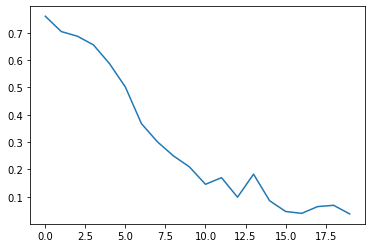

In [13]:
plt.plot(train_loss)

In [14]:
#製作測試集
testiter = iter(testLoader)
images, labels = testiter.next()

#跑測試集預測
with torch.no_grad():
    model.eval()
    images, labels = images.to(device), labels.to(device)
    pred = model(images)

In [15]:
images_np = [i.cpu() for i in images] #把圖片轉成矩陣
class_names = celeba_data.classes  #儲存['no_smile', 'smile']兩個標籤東西
print(class_names)


['no_smile', 'smile']


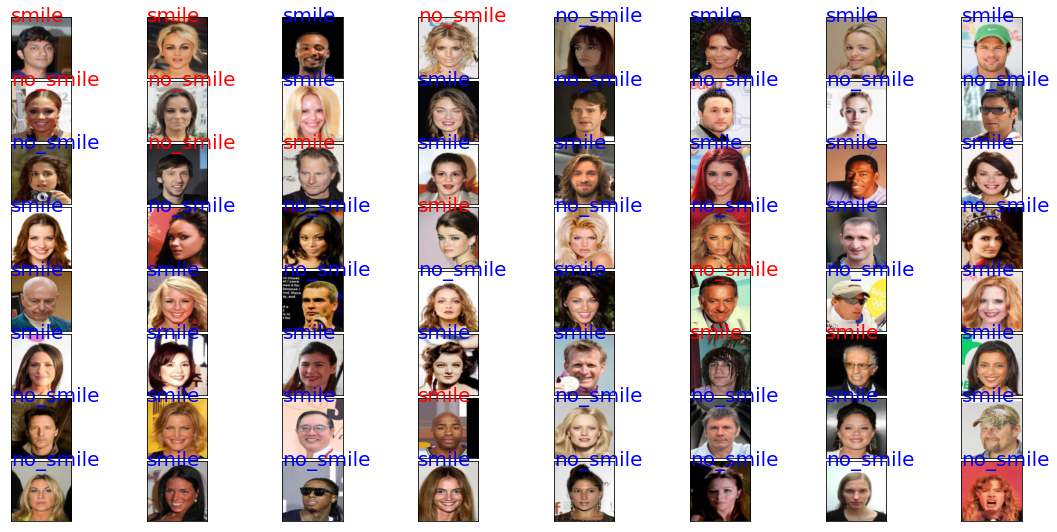

In [16]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i].permute(1,2,0)) 
    #permute為根據原本[0][1][2]的大小排成需要的樣子
    #像是images_np[i]為(3,256,256)經(1,2,0)轉換後會變成(256,256,3)

    if labels[i] == torch.max(pred[i], 0)[1]: #torch.max 出來會有兩組數字，取第1組才是預測出來的標籤
        ax.text(0, 8, class_names[torch.max(pred[i], 0)[1]], color='blue',size=20)
    else:
        ax.text(0, 8, class_names[torch.max(pred[i], 0)[1]], color='red',size=20)

tensor([[-1.3051,  1.2387]], device='cuda:0')
有笑


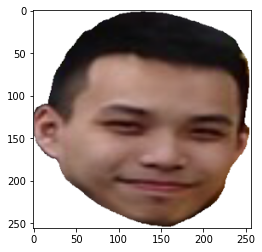

In [17]:
#測試自己的單張圖片
from PIL import Image
import torchvision.transforms as T
from torch.autograd import Variable as V
import torch as t

#讀入圖片
img = Image.open('/content/惟澤.png')  #換另一張 瑞宏.png
img = img.resize((256, 256))
plt.imshow(img)

transf = transforms.ToTensor()
iminput = transf(img)  # tensor数据格式是torch(C,H,W)

iminput = iminput.unsqueeze(0)#增加一維，輸出的img格式爲[1,C,H,W]

with torch.no_grad():
    model.eval()
    iminput = V(iminput.cuda())
    pred = model(iminput)#將圖片輸入網絡得到輸出
    print(pred)
    if torch.max(pred[0],0)[1] == 1:
        print("有笑")
    else:
        print("沒笑")
    

